<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/VU_logo.png/800px-VU_logo.png?20161029201021" width="350">

### Programming large-scale parallel systems


# All pairs of shortest paths


## Contents

In this notebook, we will learn

- How to parallelize Floyd's algorithm
- How communication can affect the correctness of a distributed algorithm


<div class="alert alert-block alert-info">
<b>Note:</b> Do not forget to run the next cell before starting studying this notebook. 
</div>

In [ ]:
using Printf

function answer_checker(answer,solution)
    if answer == solution
        "🥳 Well done!"
    else
        "It's not correct. Keep trying! 💪"
    end |> println
end
floyd_check(answer) = answer_checker(answer,"c")
floyd_impl_check(answer) = answer_checker(answer, "d")
function q1_answer(bool)
    bool || return
    msg = """
    Then we can change the loop order over i and j without changing the result. Remember:
    
    C[i,j] = min(C[i,j],C[i,k]+C[k,j])
    
    if we substitute j=k, we get
    
    C[i,k] = min(C[i,k],C[i,k]+C[k,k]).
    
    Since C[k,k]=0, thus, C[i,k] = min(C[i,k],C[i,k]), and C[i,k] = C[i,k].
    
    In other words, the value of C[i,k] will not be updated at iteration k.
    
    The same is true for i=k.
    """
    println(msg)
end
println("🥳 Well done!")

## The All Pairs of Shortest Paths (ASP) problem

In this notebook, we will parallelize the [Floyd–Warshall algorithm](https://en.wikipedia.org/wiki/Floyd%E2%80%93Warshall_algorithm) used to find a solution of the  all pairs of shortest paths (ASP) problem.

### Problem statement

- Given a graph $G$ with a distance table $C$
- Compute the length of the shortest path between any two nodes in 
$G$

We represent the distance table as a matrix $C$, where $C_{ij}$ is the distance from node $i$ to node $j$ via a direct connection (a single hop in the graph). If there is no direct connection from $i$ to $j$, this is represented using a large value in $C_{ij}$ representing infinity. 
The next figure shows a simple directed graph with 4 nodes an its corresponding distance matrix (labeled as "input").

<div>
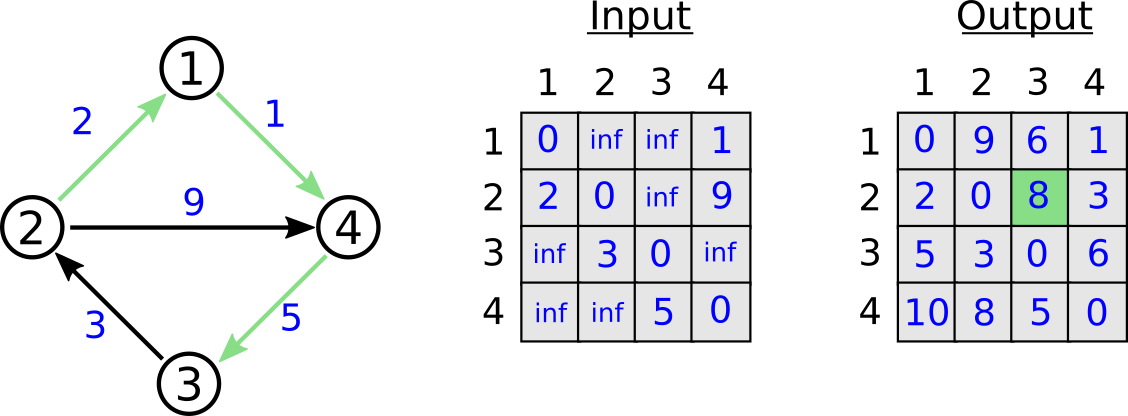
</div>
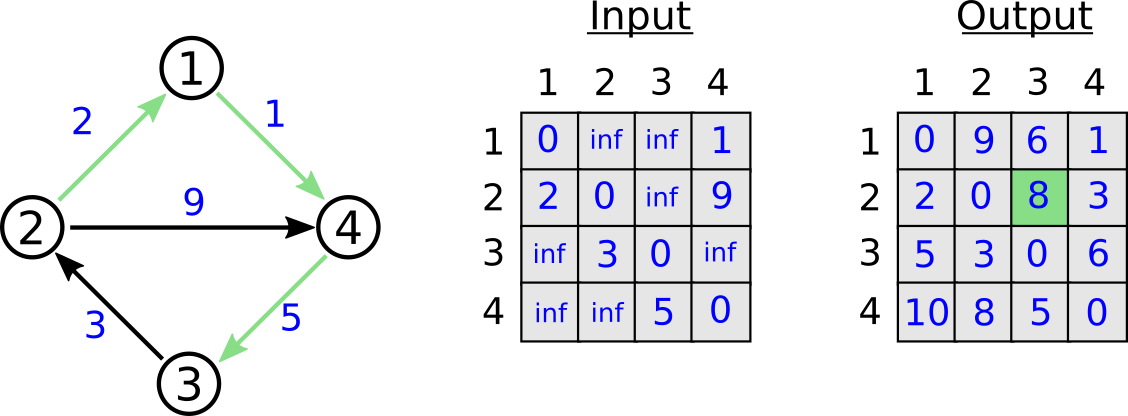

The ASP problem consists in computing the minimum distance between any two pair of nodes $i$ and $j$ in the graph. All these values can be also represented as a matrix (labeled as "output" in the figure above). For instance, the minimum distance from node 2 to node 3 is 8 as highlighted in the figure. You can understand both input and output matrices as distance tables. The key difference is that the input contains the distance using direct connections only, whereas the output contains the (minimum) distance allowing indirect connections.

### Floyd's sequential algoritm

The ASP problem can be solved with the  [Floyd–Warshall algorithm](https://en.wikipedia.org/wiki/Floyd%E2%80%93Warshall_algorithm). A sequential implementation of this algorithm is given in the following function:

In [ ]:
function floyd!(C)
  n = size(C,1)
  @assert size(C,2) == n
  for k in 1:n
    for j in 1:n
      for i in 1:n
        @inbounds C[i,j] = min(C[i,j],C[i,k]+C[k,j])
      end
    end
  end
  C
end

You can check that this function computes the solution of the small ASP problem in the figure above by executing next cell.

In [ ]:
inf = 1000
C = [
      0 inf inf   1
      2   0 inf   9
    inf   3   0 inf
    inf inf   5   0   
]
floyd!(C)

<div>
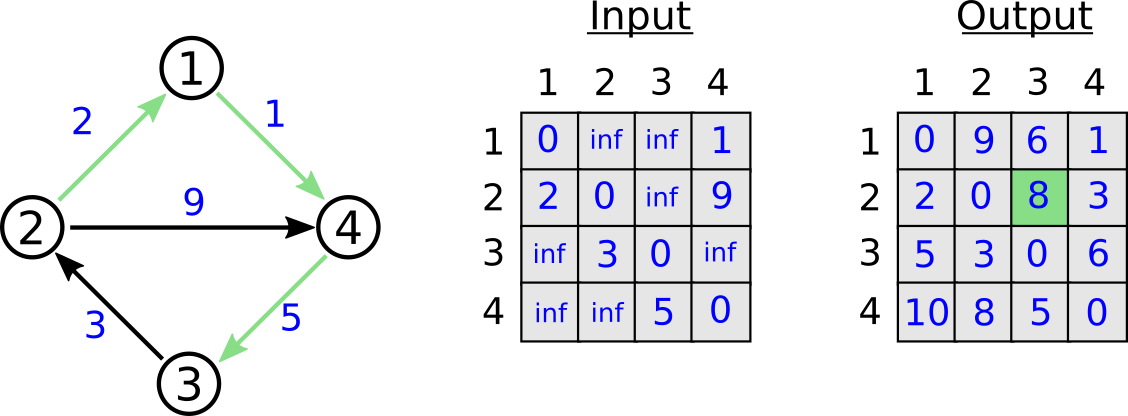
</div>
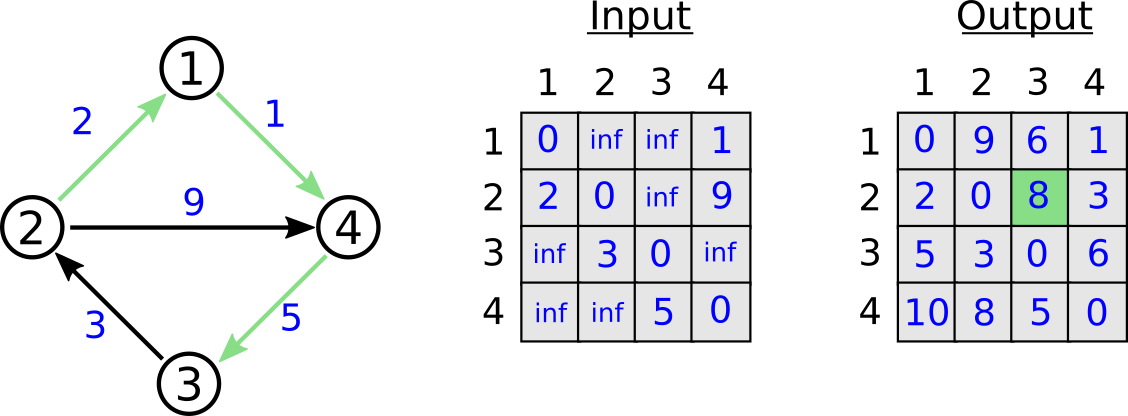

### The algorithm explained

The main idea of the  Floyd–Warshall algorithm is to perform as many iterations as nodes in the graph. At iteration $k$, we update the distance matrix $C$ by finding the shortest paths between each pair of nodes, allowing indirect paths via nodes from 1 to $k$. At the last iteration, it is allowed to visit all nodes and, thus, the distance table will contain the minimum possible distances, i.e. the solution of the ASP problem.

This process is cleverly done with three nested loops:

```julia
n = size(C,1)
for k in 1:n
    for j in 1:n
        for i in 1:n
            C[i,j] = min(C[i,j],C[i,k]+C[k,j])
        end
    end
end
```

At each outer iteration $k$, we do a loop over the distance matrix $C$. For each pair of nodes  $i$ and $j$ we compare the current distance $C_{ij}$ against the distance via node $k$, namely $C_{ik}+C_{kj}$, and update  $C_{ij}$ with the minimum. I.e., at iteration $k$ one checks if it is beneficial to visit node $k$ to reduce the distance between nodes $i$ and $j$.

<div>
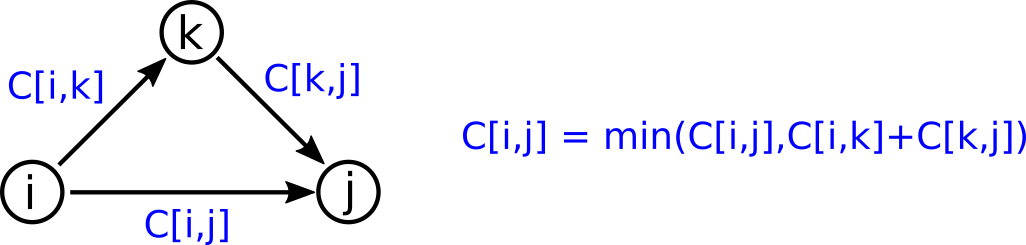
</div>

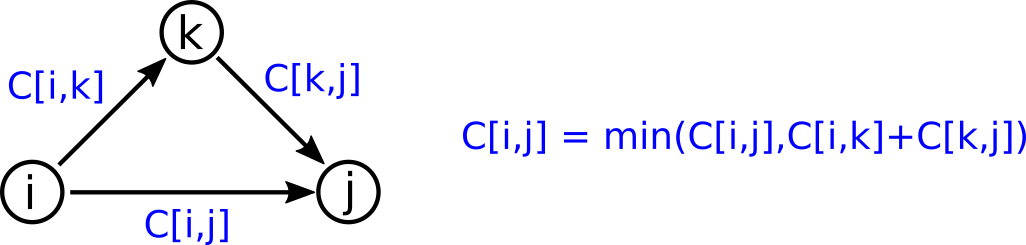

The update of the distance matrix at each iteration is illustrated in the next figure for the small ASP presented above. We highlight in green the distances that are updated in each iteration. Note that some distances that were initially infinity (i.e., no connection) will be updated with a finite value in this process. You can understand this as adding new edges in the graph as illustrated in the figures below.


<div>
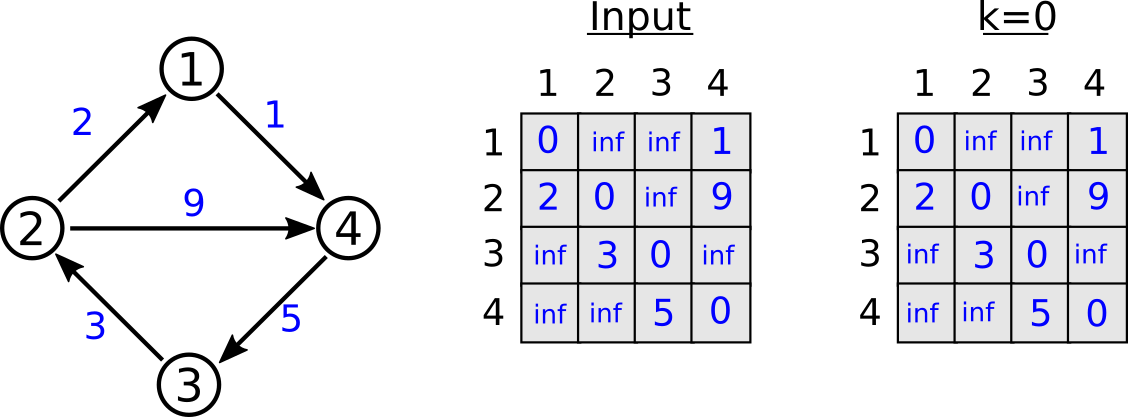
</div>
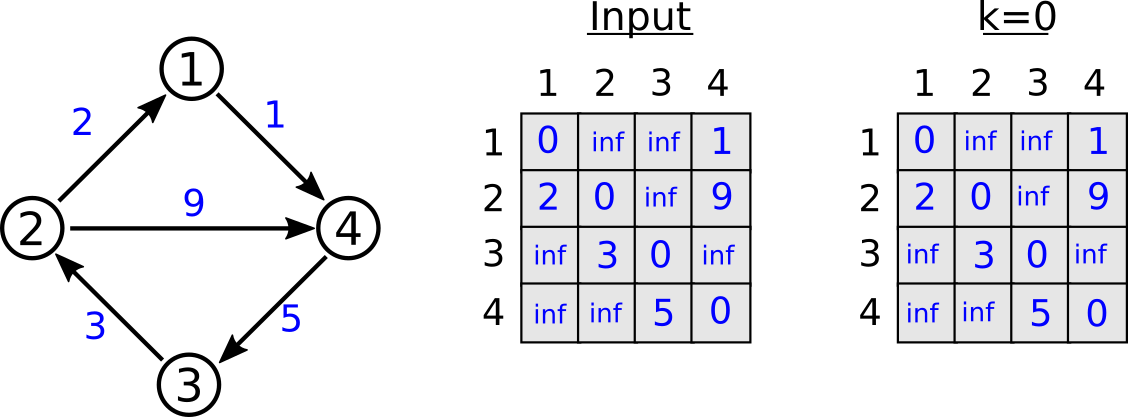

<div>
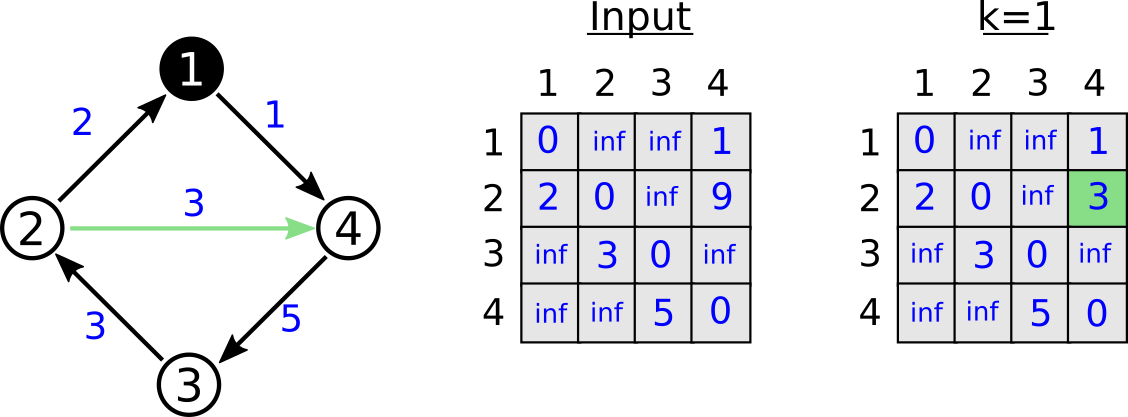
</div>
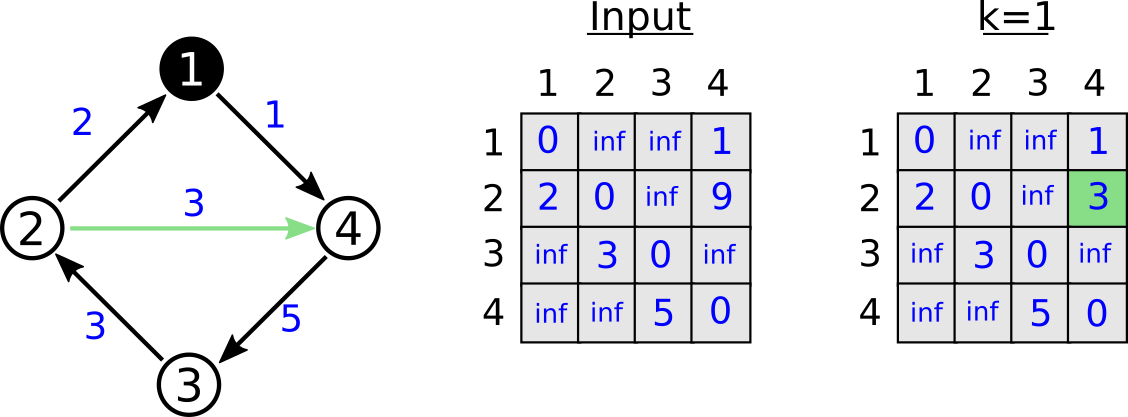

<div>
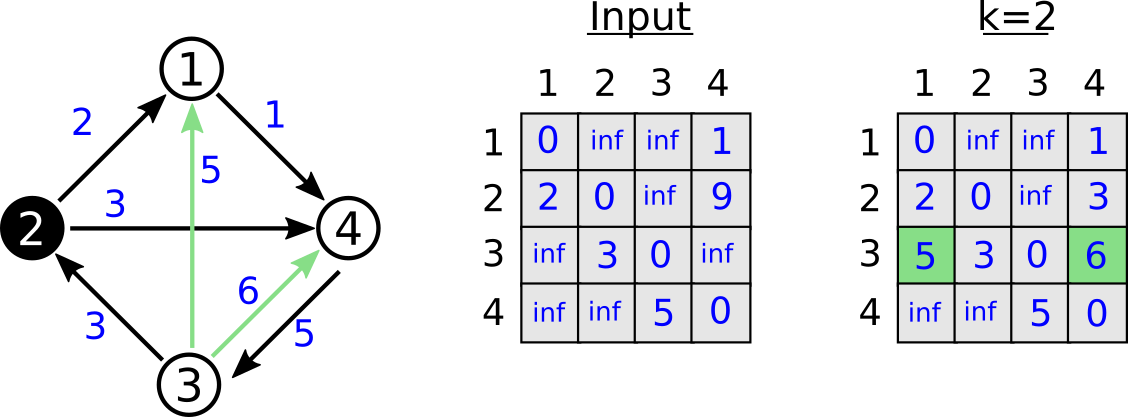
</div>
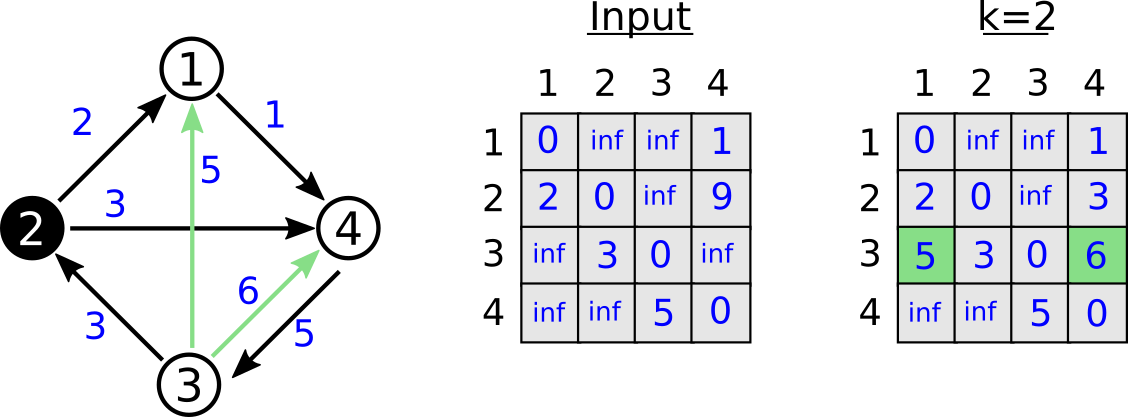

<div>
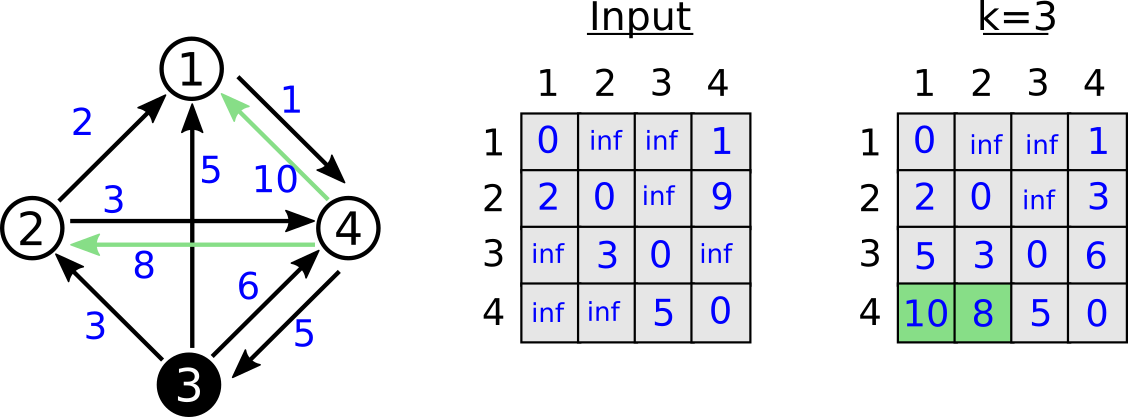
</div>
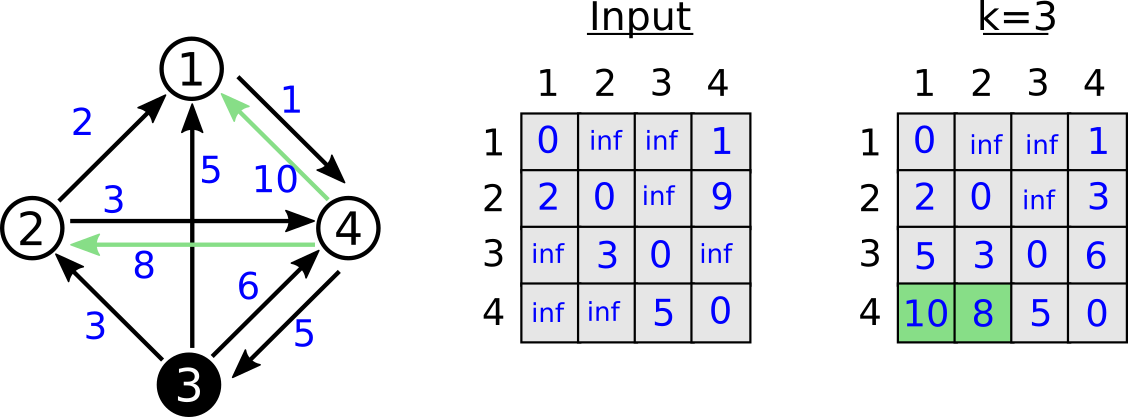

<div>
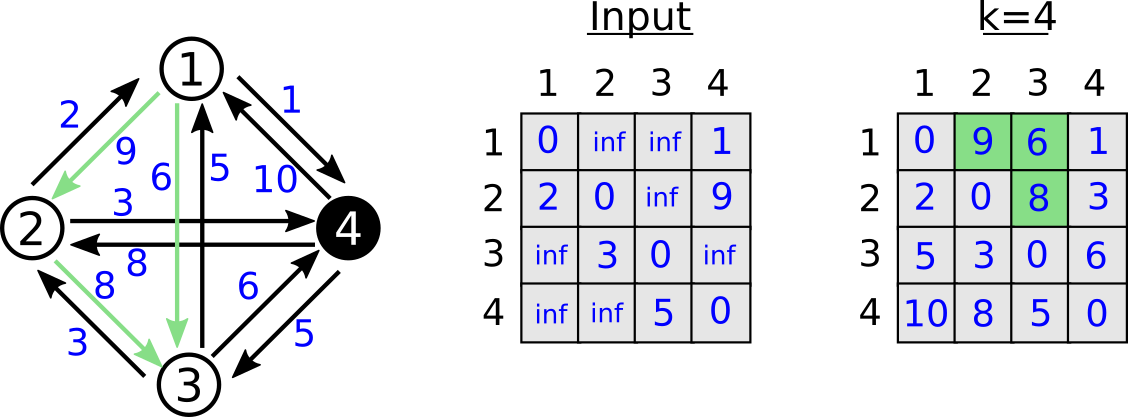
</div>
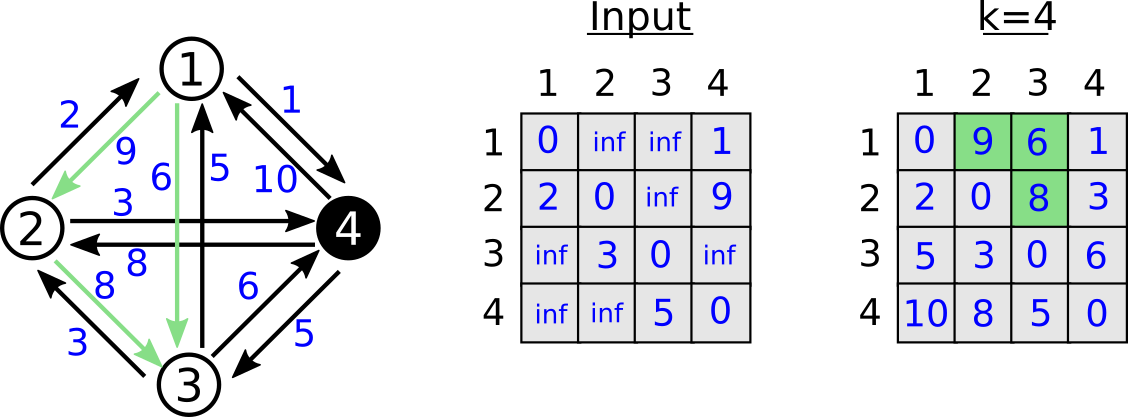

### Serial performance

Before starting to parallelize this code, we want to make sure that we have an efficient sequential implementation.  In this algorithm, the order in which we traverse the entries of matrix `C` has a significant performance impact.

The following function computes the same result as for the previous function `floyd!`, but the nesting of loops over i and j is changed.


In [ ]:
function floyd2!(C)
  n = size(C,1)
  @assert size(C,2) == n
  for k in 1:n
    for i in 1:n
      for j in 1:n
        @inbounds C[i,j] = min(C[i,j],C[i,k]+C[k,j])
      end
    end
  end
  C
end

 Compare the performance of both implementations (run the cell several times).

In [ ]:
n = 1000
C = rand(n,n)
@time floyd!(C)
C = rand(n,n)
@time floyd2!(C);

The performance difference is significant. Matrices in Julia are stored in memory in column-major order (like in Fortran, unlike in C and Python). It means that it is more efficient to access the data also in column-major order (like in function `floyd!`). See this section of [Julia's performance tips](https://docs.julialang.org/en/v1/manual/performance-tips/#man-performance-column-major) if you are interested in further details.

## Parallelization

Now, let us move to the parallelization of the method.

### Where can we exploit parallelism?

Recall:

```julia
n = size(C,1)
for k in 1:n
    for j in 1:n
        for i in 1:n
            C[i,j] = min(C[i,j],C[i,k]+C[k,j])
        end
    end
end
```

- The outer loop cannot be parallelized since the operations at iteration $k$ require the result of iteration $k-1$.
- The inner loops over $i$ and $j$ can be parallelized at a given iteration $k$.


<div class="alert alert-block alert-success">
<b>Question (hard):</b>  Can we really parallelize the loops over `i` and `j` ? To compute `C[i,j]` at iteration `k`, we first need to compute `C[i,k]` and `C[k,j]`. In order words, it seems that the order of the loops over `i` and `j` cannot be arbitrary. However,  this is not really true, why?
</div>

In [ ]:
uncover = false
q1_answer(true)

### Parallelization strategy

As for the matrix-matrix product and Jacobi, any of the iterations over $i$ and $j$ are independent and could be computed on a different processor. However, we need a larger grain size for performance reason. Here, we adopt the same strategy as for algorithm 3 in the matrix-matrix product:

- Each process will update a subset of consecutive rows of the distance table $C$ at each iteration $k$.

<div>
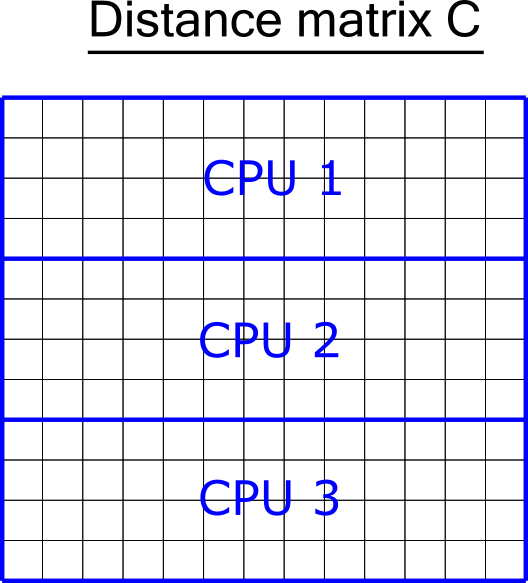
</div>
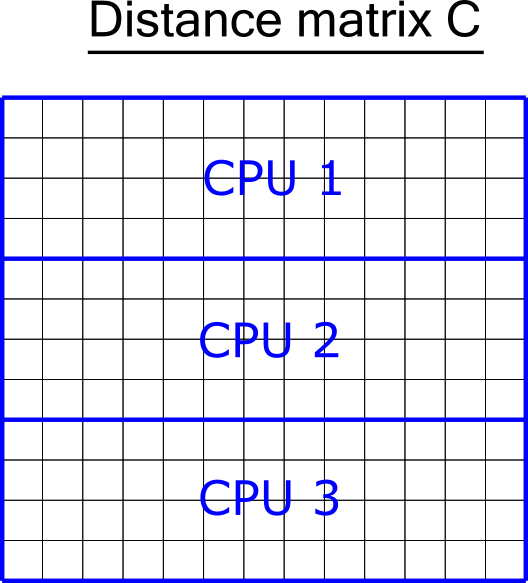

### Data dependencies

Recall: we perform this update at iteration $k$:

`C[i,j] = min(C[i,j],C[i,k]+C[k,j])`

If each process updates a block of rows of matrix $C$, which data do we need for this operation?


<div>
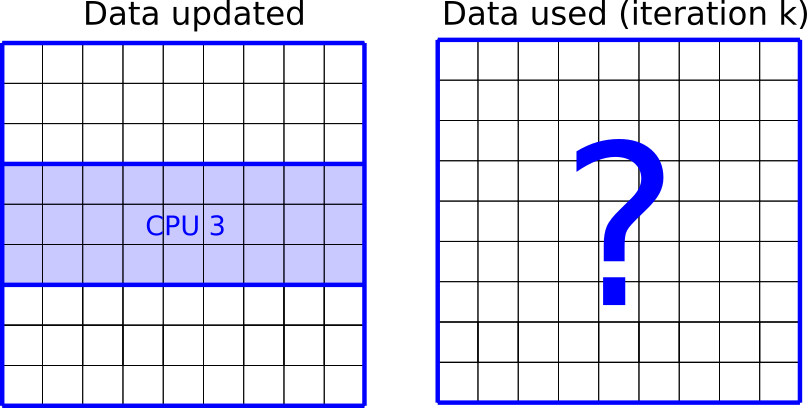
</div>
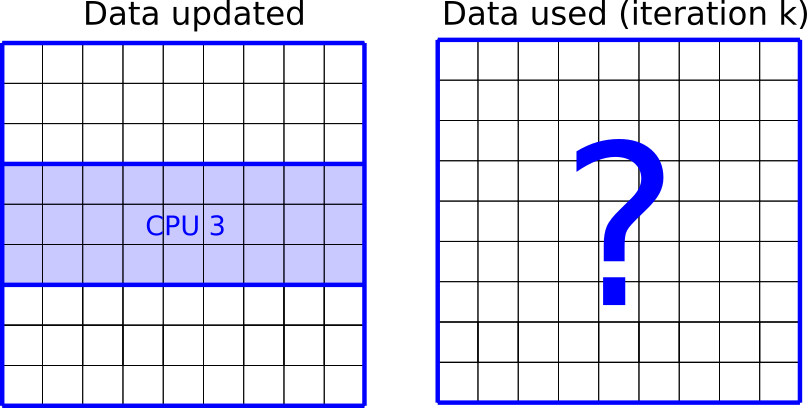

At each iteration, the processor needs the input values `C[i,j]`, `C[i,k]` and `C[k,j]`. Since we split the data row-wise, the process already has values `C[i,j]` and `C[i,k]`. However, `C[k,j]` may be stored in a different process. See figure below.

<div>
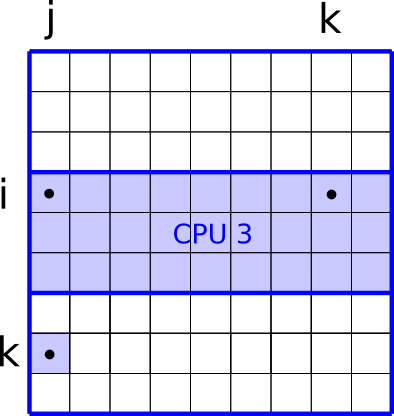
</div>
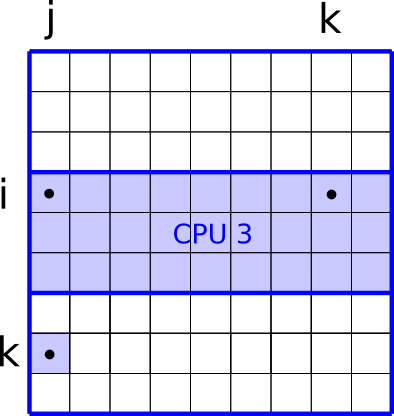

As we iterate over columns $j$, the process needs input from all values of row $k$. Therefore, at the start of iteration $k$, the whole row $k$ needs to be communicated.

<div>
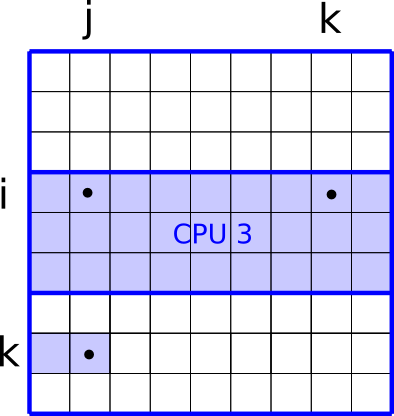
</div>
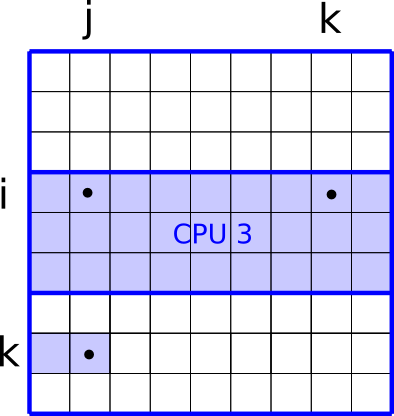

In summary, at iteration $k$ a given process will need row number $k$ which might be stored remotely in another process. The owner of row $k$ needs to *broadcast* this row to the other processes at iteration $k$.

<div>
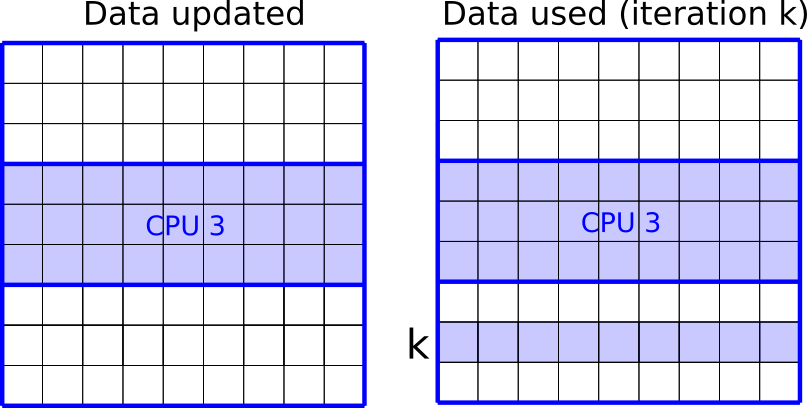
</div>
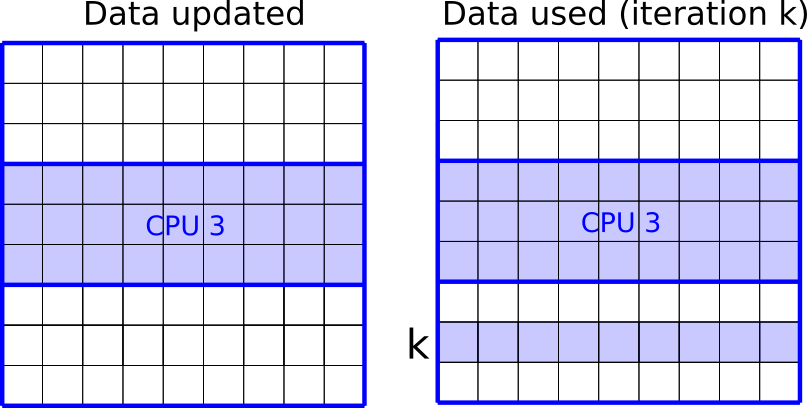

<div class="alert alert-block alert-success">
<b>Question:</b>  How much data is send from the owner of row k in each iteration in this parallel algorithm?
</div>

    a) O(N²/P)
    b) O(N)
    c) O(NP)
    d) O(P)

In [ ]:
answer = "x" # replace x with a, b, c or d
floyd_check(answer)

### Theoretical performance analysis

### Computation complexity

Each process updates $N^2/P$ entries per iteration. The computation complexity per iteration is $O(N^2/P)$.

<div>
    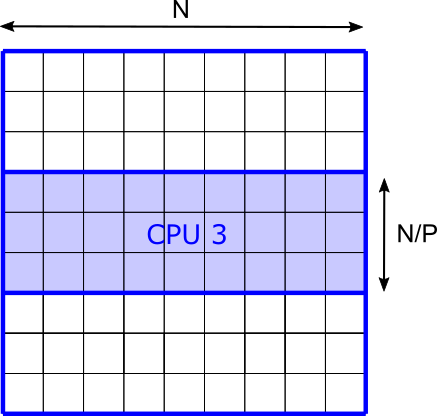
    </div>
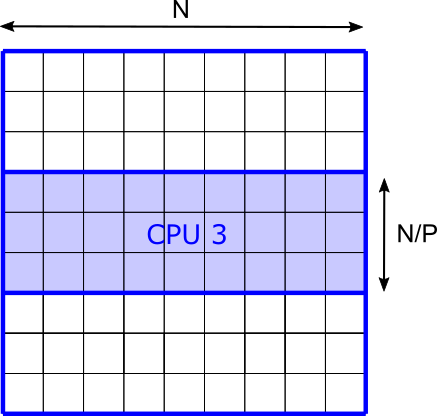

### Communication complexity

- One process broadcasts a message of length $N$ to $P-1$ processes per iteration. Thus, the **send cost** is $O(N P)$ per iteration.
- $P-1$ processes receive one message of length $N$ per iteration. Hence, the **receive cost** is $O(N)$ per iteration at each process. 

<div>
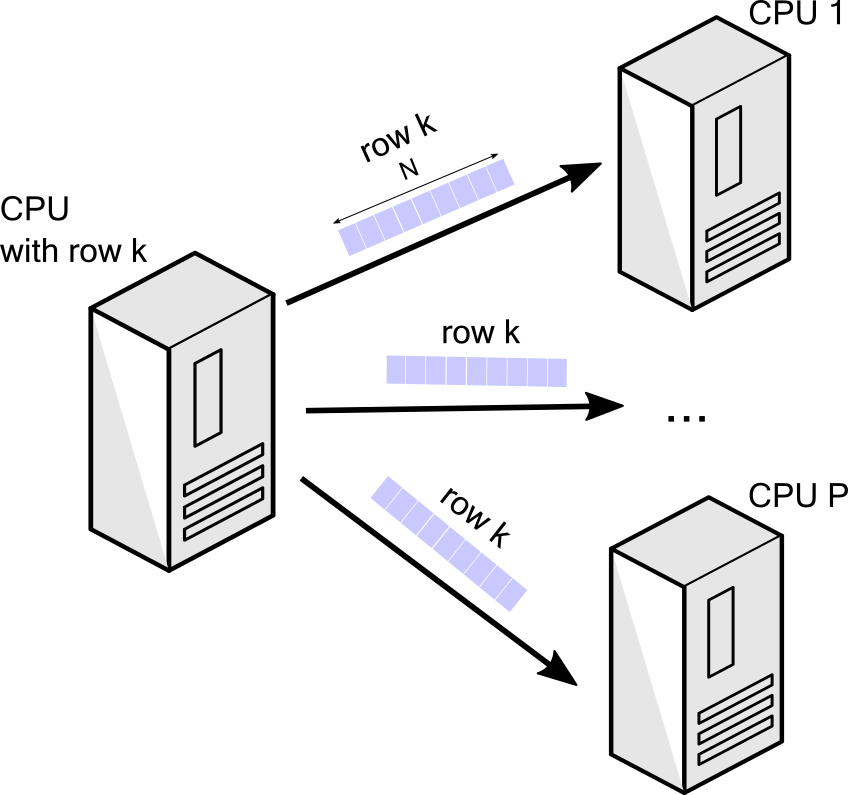
</div>
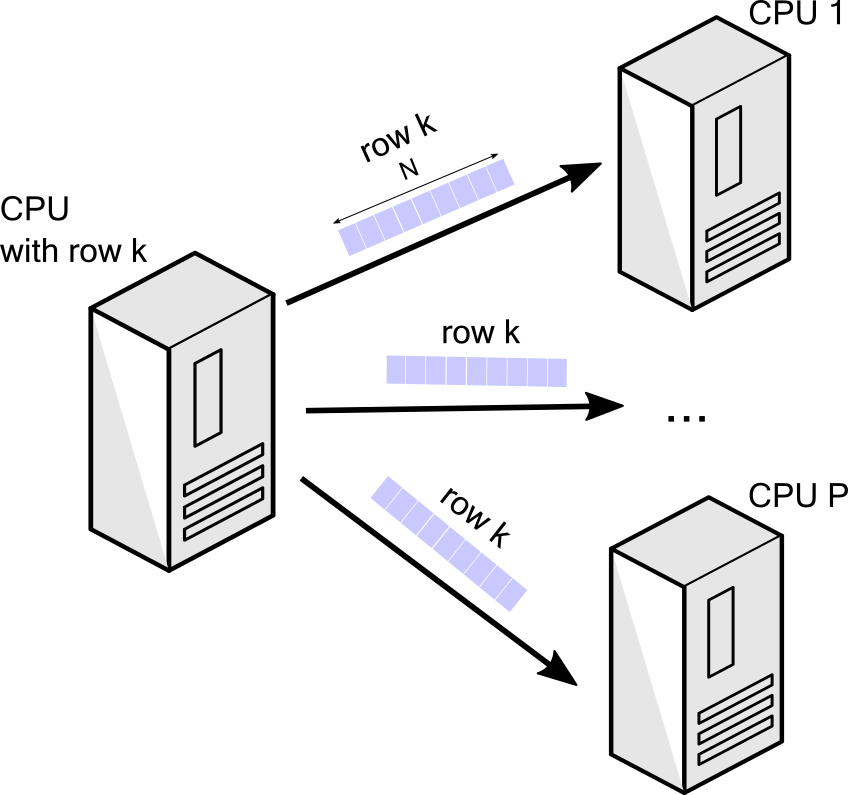

The communication over computation cost is

- On the send side: $O(NP)/O(N^2/P) = O(P^2/N)$
- On the receive side $O(N)/O(N^2/P) = O(P/N)$


In summary, the send/computation ratio is $O(P^2/N)$ and the receive/computation ratio is $O(P/N)$.  The algorithm is potentially scalable if $P^2<<N$. Note that this is worse than for matrix-matrix multiplication, which is scalable for $P<<N$. I.e., you need a larger problem size in the current algorithm than in matrix-matrix multiplication.

## Parallel Implementation

Now, we will explore the parallel implementation of Floyd's algorithm. We will use MPI.

In [ ]:
] add MPI

In [ ]:
using MPI

We are going to implement the method in a function with the following signature

```julia
    floyd_mpi!(C,comm)
```

The signature is similar to the sequential function `floyd!(C)`, but there are some important differences

- This function is going to be called on several MPI ranks, but only one rank (rank 0 in the implementation below) will receive the input matrix, the other ranks will receive an empty matrix. It would not be memory efficient if all ranks receive a copy of the input matrix as this one could be very large.

- On output, only the value of C will be correct on rank 0. It will not be efficient to try to write the result on all ranks.

- The parallel function takes an MPI communicator object. This allows the user to decide which communicator to use. For instance, `MPI.COMM_WORLD` directly or a duplicate of this one (which is the recommended approach).

<div>
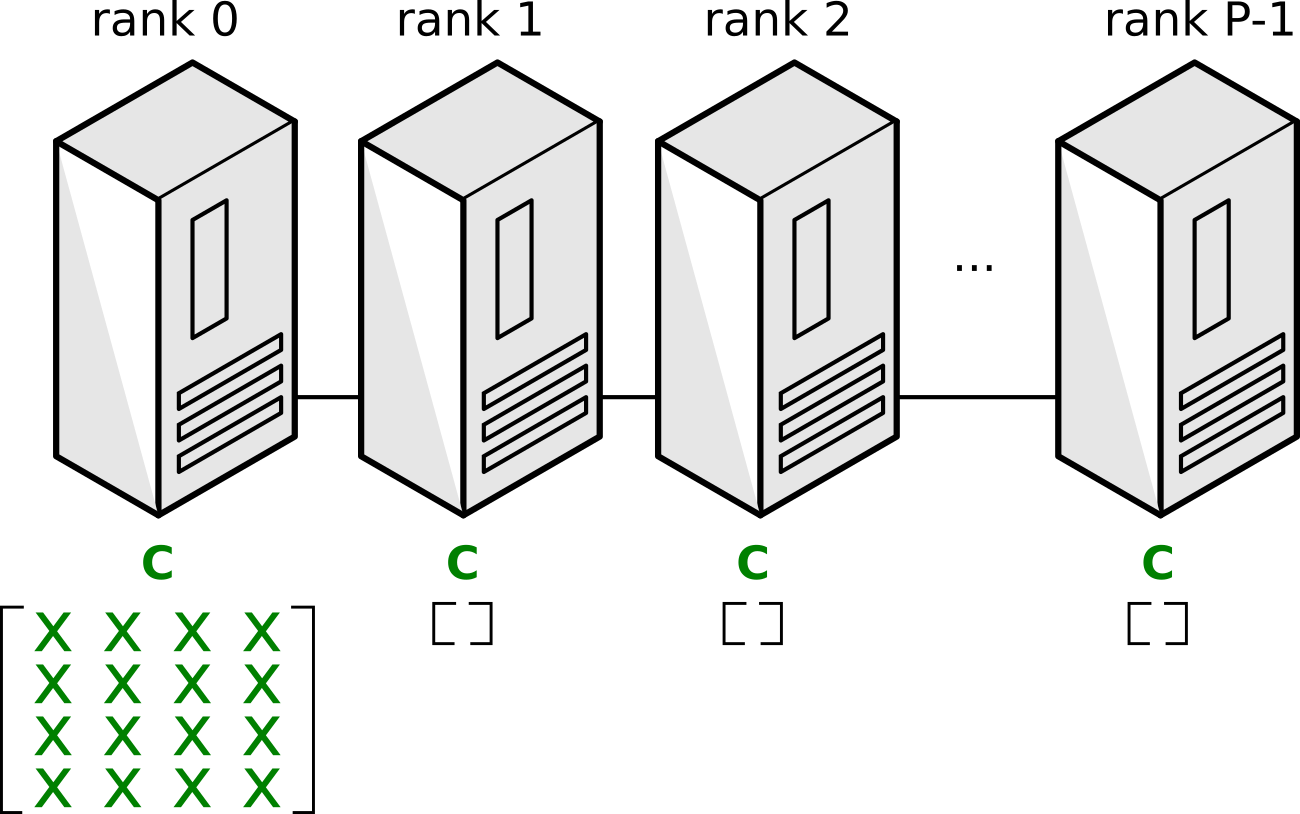
</div>
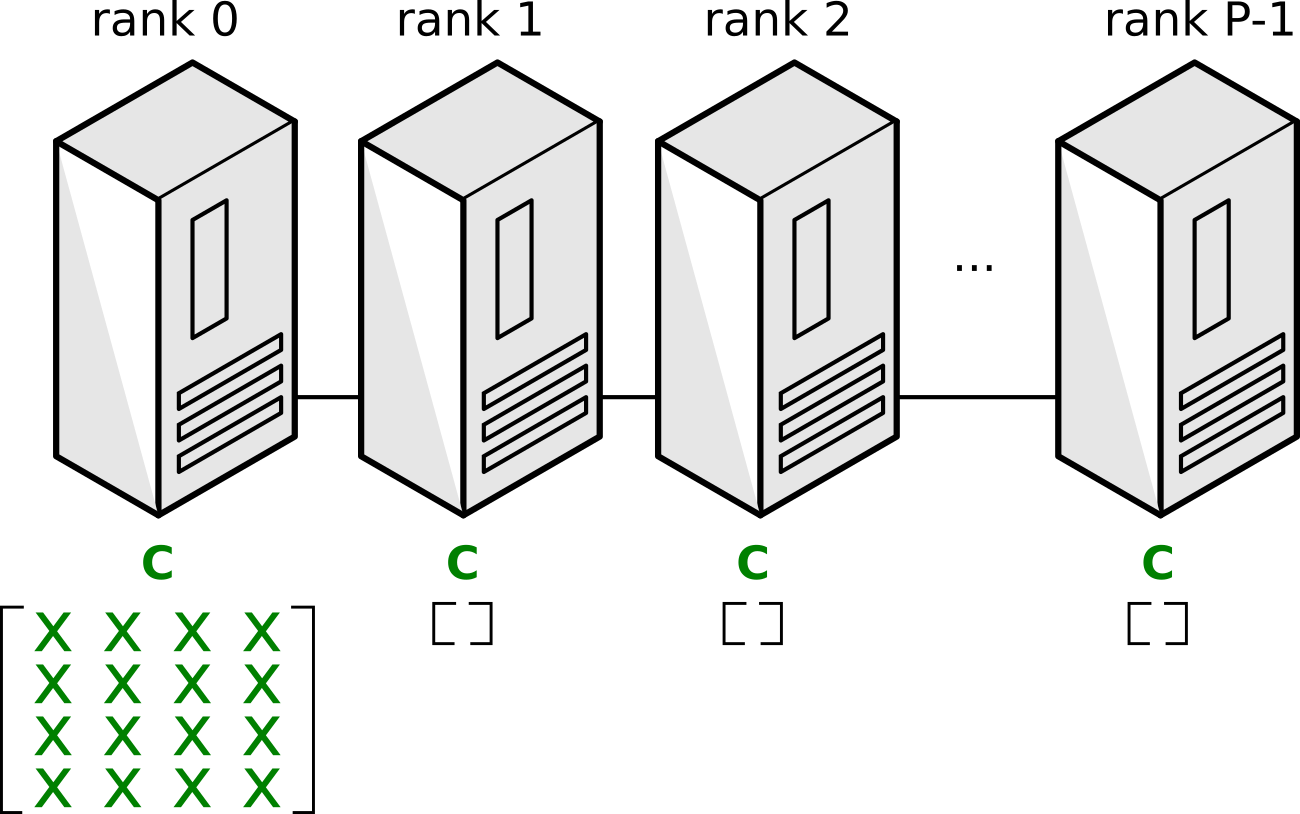

The implementation of the parallel function is given in the following code snipped:

In [ ]:
code1 = quote
    function floyd_mpi!(C,comm)
        myC = distribute_input(C,comm)
        floyd_iterations!(myC,comm)
        collect_result!(C,myC,comm)
    end
end;

In the following cells, we discuss the implementation of the helper functions `distribute_input`, `floyd_iterations!`, and `collect_result!`.

### Distributing the input matrix

Since only rank 0 receives the input matrix C, this rank needs to split it row-wise and
send the pieces to all other ranks. This is done in the function below. We start by communicating the problem size N to all ranks (at the start only rank 0 knows the problem size). This is trivially done with an `MPI.Bcast!`. Once all ranks know the problem size, they can allocate space for their local part of `C` , called `myC` in the code. After this, rank 0 sends the pieces to all other ranks. We do it here with `MPI.Send` and `MPI.Recv!`. This can also be done with `MPI.Scatter!`, but it is more challenging since we are using a row partition and Julia stores the matrices in column major order. Note that this algorithm can also be implemented using a column partition. In this case, using `MPI.Scatter!` would probably be the best option.


<div>
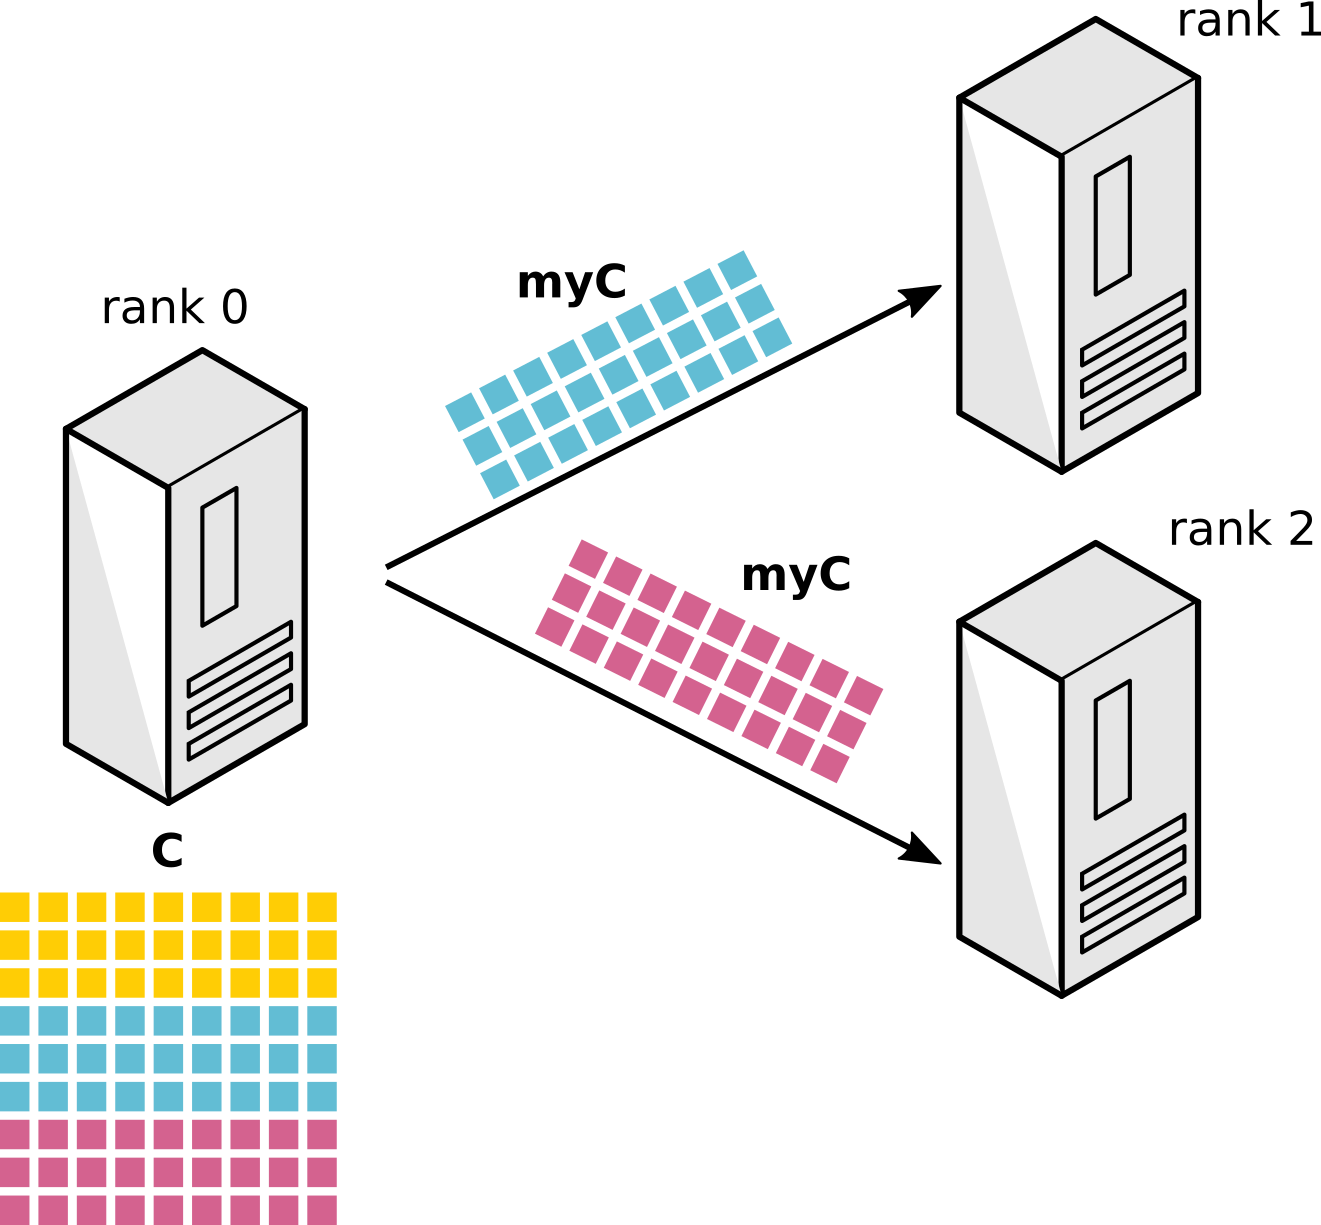
</div>
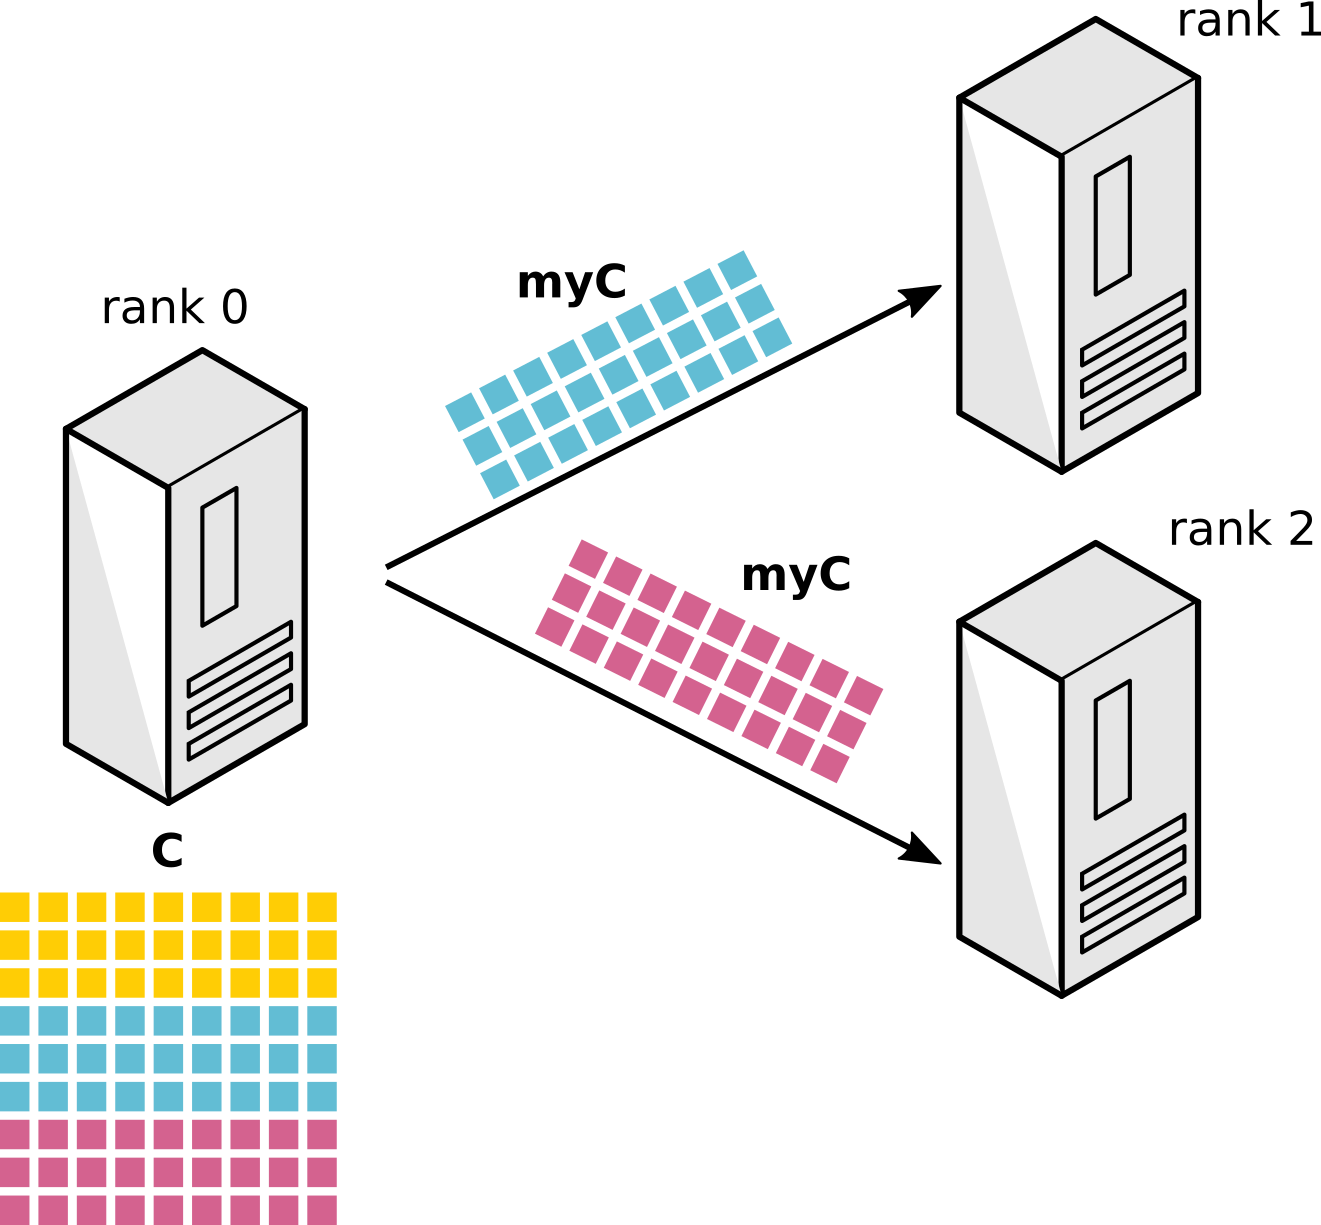

In [ ]:
code2 = quote
    function distribute_input(C,comm)
        rank = MPI.Comm_rank(comm)
        P = MPI.Comm_size(comm)
        # Communicate problem size
        if rank == 0
            N = size(C,1)
            if mod(N,P) !=0
                println("N not multiple of P")
                MPI.Abort(comm,-1)
            end
            Nref = Ref(N)
        else
            Nref = Ref(0)
        end
        MPI.Bcast!(Nref,comm;root=0)
        N = Nref[]
        # Distribute C row-wise
        L = div(N,P)
        myC = similar(C,L,N)
        if  rank == 0
            lb = L*rank+1
            ub = L*(rank+1)
            myC[:,:] = view(C,lb:ub,:)
            for dest in 1:(P-1)
                lb = L*dest+1
                ub = L*(dest+1)
                MPI.Send(view(C,lb:ub,:),comm;dest)
            end
        else
            source = 0
            MPI.Recv!(myC,comm;source)
        end
        return myC
    end
end;

### Running Floyd's updates in parallel

As discussed above, we need to communicate row $k$ of matrix $C$ in order to perform iteration $k$ of the algorithm. The function below is similar to the sequential function `floyd!`, but there is a key difference. At the start of iteration $k$, the owner of row $k$ sends it to the other processors. Once row $k$ is available, all ranks can do the Floyd update locally on their portion of matrix $C$.

<div>
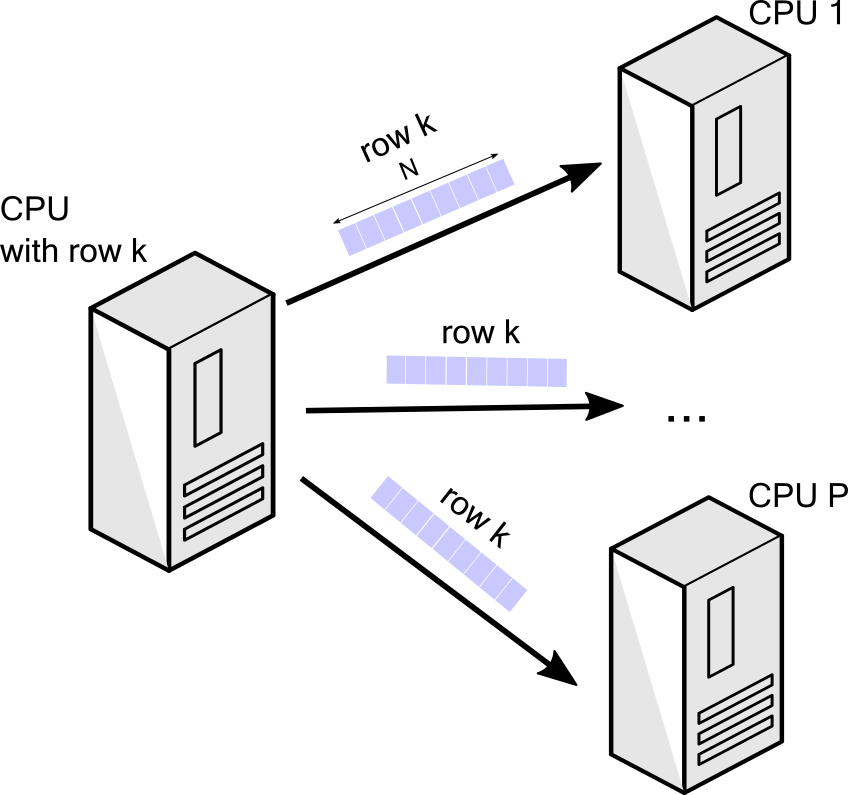
</div>
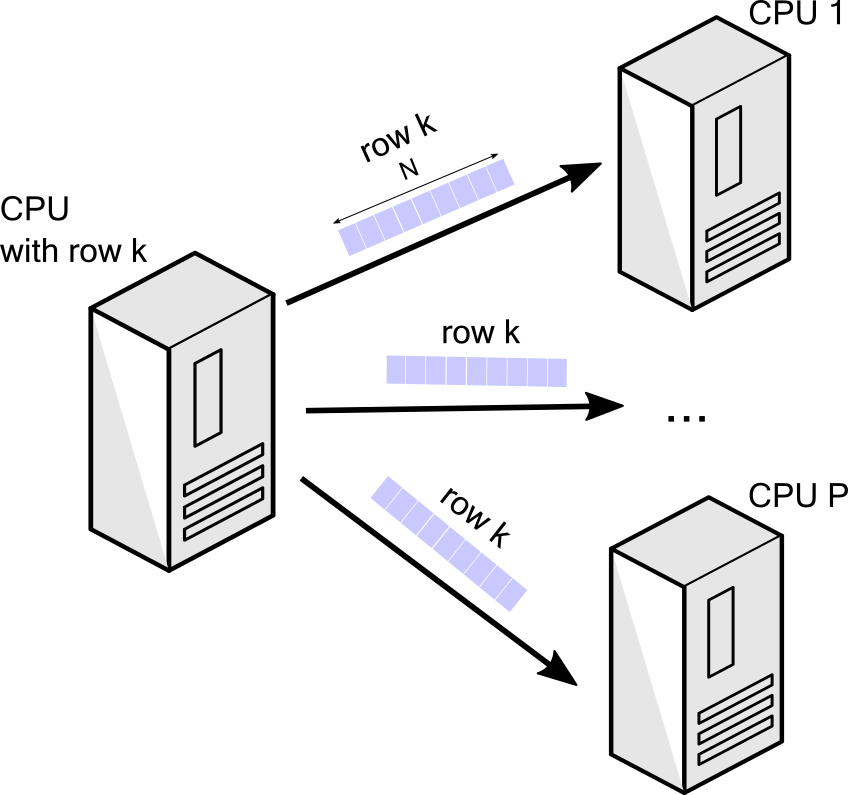

In [ ]:
code3 = quote
    function floyd_iterations!(myC,comm)
        L = size(myC,1)
        N = size(myC,2)
        rank = MPI.Comm_rank(comm)
        P = MPI.Comm_size(comm)
        lb = L*rank+1
        ub = L*(rank+1)
        C_k = similar(myC,N)
        for k in 1:N
            if (lb<=k) && (k<=ub)
                # Send row k to other workers if I have it
                myk = (k-lb)+1
                C_k[:] = view(myC,myk,:)
                for dest in 0:(P-1)
                    if rank == dest
                        continue
                    end
                    MPI.Send(C_k,comm;dest)
                end
            else
                # Wait until row k is received
                MPI.Recv!(C_k,comm,source=MPI.ANY_SOURCE)
            end
            # Now, we have the data dependencies and
            # we can do the updates locally
            for j in 1:N
                for i in 1:L
                    myC[i,j] = min(myC[i,j],myC[i,k]+C_k[j])
                end
            end
        end
        myC
    end
end;

### Collecting back the results

At this point, we have solved the ASP problem, but the solution is cut in different pieces, each one stored on a different MPI rank. It is often useful to gather the solution into a single matrix, e.g., to compare it against the sequential algorithm.The following function collects all pieces and stores them in $C$ on rank 0. Again, we implement this with `MPI.Send` and `MPI.Recv!` as it is easier as we are working with a row partition. However, we could do it also with `MPI.Gather!`.

<div>
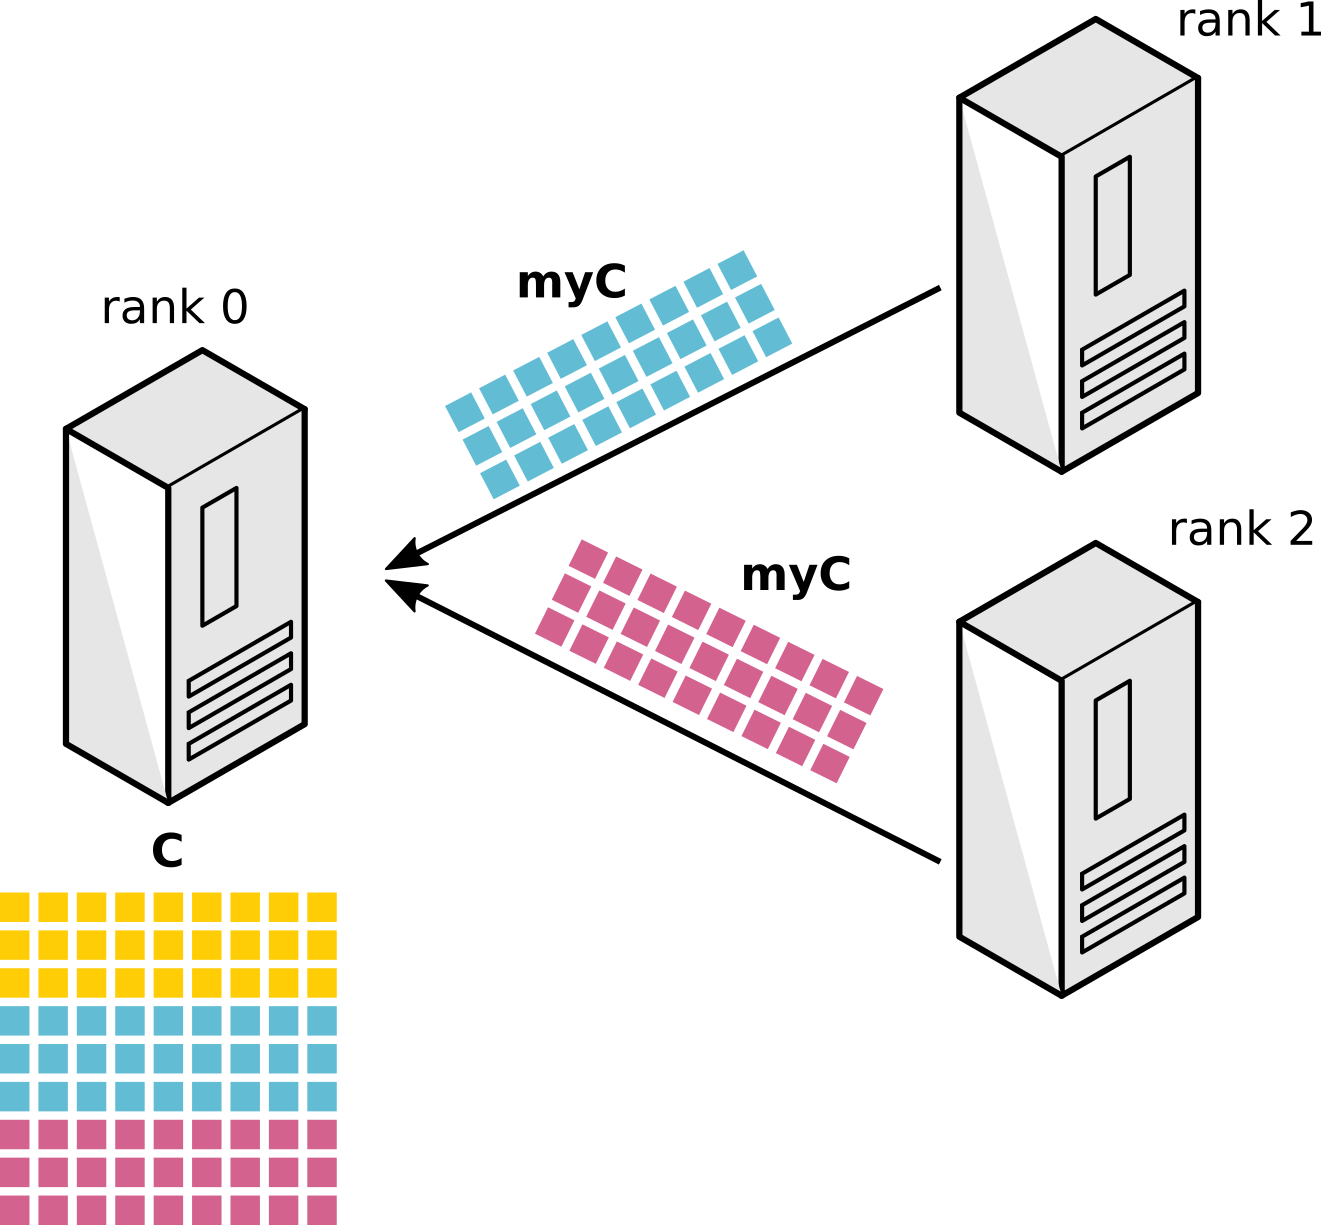
</div>
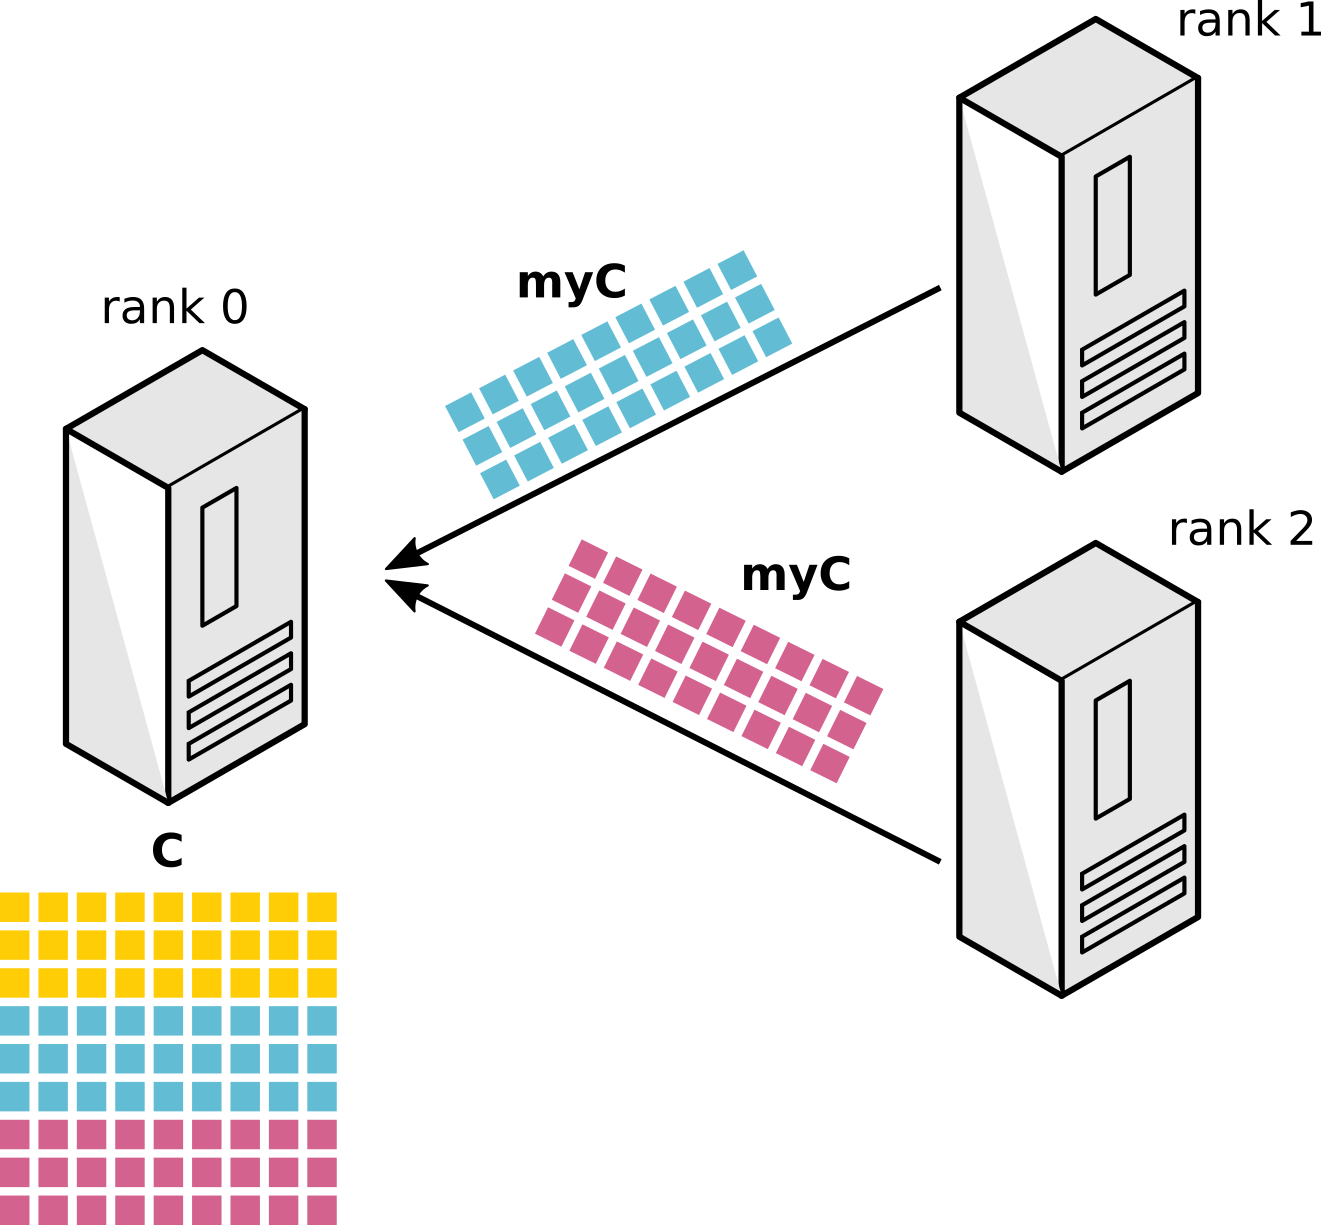

In [ ]:
code4 = quote
    function collect_result!(C,myC,comm)
        L = size(myC,1)
        rank = MPI.Comm_rank(comm)
        P = MPI.Comm_size(comm)
        if rank == 0
            lb = L*rank+1
            ub = L*(rank+1)
            C[lb:ub,:] = myC
            for source in 1:(P-1)
                lb = L*source+1
                ub = L*(source+1)
                MPI.Recv!(view(C,lb:ub,:),comm;source)
            end
        else
            dest = 0
            MPI.Send(myC,comm;dest)
        end
        C
    end
end;

### Running and testing the code

In the cell below, we run the parallel code and compare it against the sequential. Note that we can only compare both results on rank 0 since this is the only one that contains the result of the parallel code. We have also included a function that generates random distance tables of a given size $N$.

In [ ]:
code = quote
    using MPI
    MPI.Init()
    $code1
    $code2
    $code3
    $code4
    function input_distance_table(n)
        threshold = 0.1
        mincost = 3
        maxcost = 9
        inf = 10000
        C = fill(inf,n,n)
        for j in 1:n
            for i in 1:n
                if rand() > threshold
                    C[i,j] = rand(mincost:maxcost)
                end
            end
            C[j,j] = 0
        end
        C
    end
    function floyd!(C)
        n = size(C,1)
      @assert size(C,2) == n
      for k in 1:n
        for j in 1:n
          for i in 1:n
            @inbounds C[i,j] = min(C[i,j],C[i,k]+C[k,j])
          end
        end
      end
      C
    end
    comm = MPI.Comm_dup(MPI.COMM_WORLD)
    rank = MPI.Comm_rank(comm)
    if rank == 0
        N = 24
    else
        N = 0
    end
    C = input_distance_table(N)
    C_par = copy(C)
    floyd_mpi!(C_par,comm)
    if rank == 0
        C_seq = copy(C)
        floyd!(C_seq)
        if C_seq == C_par
            println("Test passed 🥳")
        else
            println("Test failed")
        end
    end
end
run(`$(mpiexec()) -np 3 julia --project=. -e $code`);

## Is this implementation correct?

In the cell above, the result of the parallel code was probably the same as for the sequential code. However, is this sufficient to assert that the code is correct? Unfortunately, it is not. In fact, **the parallel code we implemented is not correct!** There is no guarantee that this code computes the correct result. This is why:

In MPI, point-to-point messages are *non-overtaking* between a given sender and receiver. Say that process 1 sends several messages to process 3. All these will arrive in FIFO order. This is according to section 3.5 of the MPI standard 4.0.
Unfortunately, this is not enough in our case. The messages could arrive in the wrong order *from different senders*. If process 1 sends messages to process 3, and then process 2 sends other messages to process 3, it is not granted that process 3 will receive first the messages from process 1 and then from process 2 (see figure below).

If we are lucky all messages will arrive in order. In our parallel code, all processors would receive first row one, then row 2, then row 3, etc. The computed result will be correct.

<div>
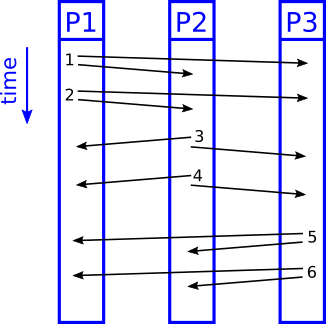
</div>
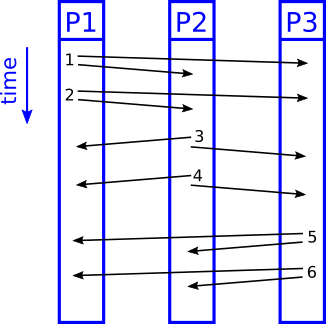

However, FIFO ordering between pairs of processors is not enough to guarantee that rows arrive in consecutive order. The next figure shows a counter example. In this case, communication between process 1 and process 3 is particularly slow for some unknown reason. As result processor 3 receives first messages from processor 2, even though processor 1 sent the messages first. In our parallel code, the received rows would be first row 3, then row 4, then row 1, then row 2, which is not correct. Note however that process 3 received all messages from process 1 in the correct order (guaranteed by MPI). But this is not enough in our algorithm.

<div>
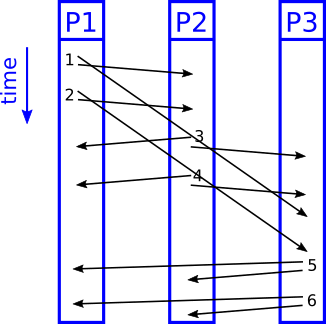
</div>
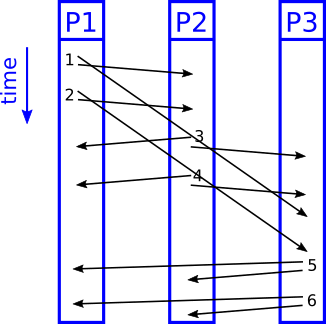

### Possible solutions

There are several solution to this synchronization problem:

1. **Synchronous sends**: Use synchronous send MPI_SSEND. This is less efficient because we spend time waiting until each message is received. Note that the blocking send MPI_SEND used above does not guarantee that the message was received. 
2. **MPI.Barrier**: Use a barrier at the end of each iteration over $k$. This is easy to implement, but we get a  synchronization overhead.
3. **Order incoming messages**: The receiver orders the incoming messages, e.g. using to MPI.Status to get the sender rank. This requires buffering and extra user code.
4. **MPI.Bcast!**: Communicate row k using `MPI.Bcast!`. One needs to know which are the rows owned by the other ranks since we cannot use `MPI.ANY_SOURCE` in `MPI.Bcast!`. This is trivial however if the number of rows is multiple of the number of ranks.

## Summary

- We learned how to parallelize Floyd's algorithm.
- The considered strategy based on a row-wise data partition has little communication overhead if the problem size is large enough.
- One needs to be careful in which order the messages are received to have a correct algorithm.
- There are several strategies to solve this synchronization problem, each one with pros and cons.


## Exercise

### Exercise 1

Modify the `floyd_iterations!` function so that it is guaranteed that the result is computed correctly. Use `MPI.Bcast!` to solve the synchronization problem. Note: only use `MPI.Bcast!`in `floyd_iterations!`, do not use other MPI directives. You can assume that the number of rows is a multiple of the number of processes.

# License



This notebook is part of the course [Programming Large Scale Parallel Systems](https://www.francescverdugo.com/XM_40017) at Vrije Universiteit Amsterdam and may be used under a [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/) license.